# Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 4.2 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 


In [2]:
import numpy as np
import pickle
import pprint
from matplotlib import pyplot as plt
import pypianoroll
import IPython.display
import pickle
import tensorflow as tf
from tensorflow import keras
from keras import layers

np.random.seed(10)

# Load dataset

In [6]:
with open('/content/drive/MyDrive/Applied DL Music/dataset_for_vae_piano_256x32_float16.pkl', 'rb') as f:
    piano_dataset = pickle.load(f)
piano_dataset.shape

In [ ]:
reshaped_piano_dataset = np.expand_dims(piano_dataset, -1)

In [ ]:
sub_piano_dataset = reshaped_piano_dataset[:100]
print(sub_piano_dataset.shape)

(100, 1024, 128, 1)


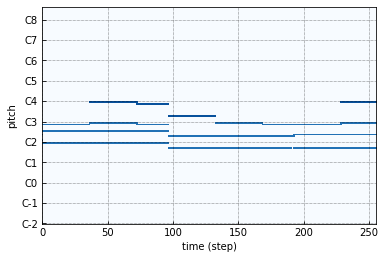

In [11]:
piano_sample = piano_dataset[10] * 127
piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=piano_sample)
pypianoroll.plot(piano_track)
plt.show()

In [12]:
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 24, tracks = [piano_track])
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)

# VAE

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [78]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(256, 128))
x = layers.Reshape((256, 128, 1))(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 128)]   0           []                               
                                                                                                  
 reshape_10 (Reshape)           (None, 256, 128, 1)  0           ['input_14[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 64, 32)  320         ['reshape_10[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 32, 64)   18496       ['conv2d_11[0][0]']              
                                                                                            

In [79]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512)(latent_inputs)
x = layers.Dense(256 * 128, activation="relu")(x)
decoder_outputs = layers.Reshape((256, 128))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_20 (Dense)            (None, 512)               8704      
                                                                 
 dense_21 (Dense)            (None, 32768)             16809984  
                                                                 
 reshape_11 (Reshape)        (None, 256, 128)          0         
                                                                 
Total params: 16,818,688
Trainable params: 16,818,688
Non-trainable params: 0
_________________________________________________________________


In [72]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    (data - reconstruction)**2, axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        


In [117]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(piano_dataset[:10], epochs=100, batch_size=64)

Epoch 1/100
1/1 [==============================] - 1s 729ms/step - loss: 255.1700 - reconstruction_loss: 247.4154 - kl_loss: 7.7546
Epoch 2/100
1/1 [==============================] - 0s 16ms/step - loss: 253.7254 - reconstruction_loss: 246.1492 - kl_loss: 7.5762
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 246.5103 - reconstruction_loss: 238.6914 - kl_loss: 7.8189
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 243.7430 - reconstruction_loss: 235.6456 - kl_loss: 8.0974
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 243.6019 - reconstruction_loss: 235.3148 - kl_loss: 8.2871
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 240.1883 - reconstruction_loss: 232.0227 - kl_loss: 8.1655
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 233.0813 - reconstruction_loss: 225.1135 - kl_loss: 7.9678
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 231.3941 -

# Inference

In [83]:
latent_vect = np.random.normal(0, 10, size=latent_dim)
latent_vect.shape

(16,)

In [119]:
#idx = 288
idx = 9

In [120]:
input_data = np.expand_dims(np.array([piano_dataset[idx]]), -1)
print(input_data.shape)
_, _, z = np.array(vae.encoder(input_data))
output_data = vae.decoder(z)
print(output_data.shape)

(1, 256, 128, 1)
(1, 256, 128)


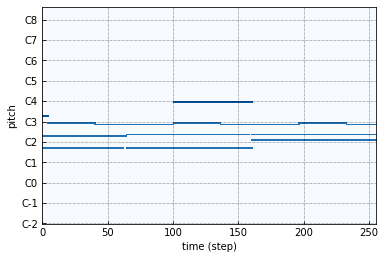

In [121]:
use_input_data = np.squeeze(input_data[0])
piano_sample = use_input_data * 127
piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=piano_sample)
pypianoroll.plot(piano_track)
plt.show()

In [111]:
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 24, tracks = [piano_track])
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)

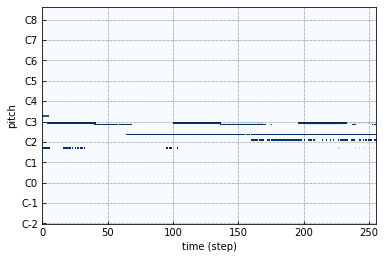

In [123]:
use_data = np.squeeze(output_data[0])
piano_sample = use_data * 257
piano_track = pypianoroll.StandardTrack(name='Piano', program=0, is_drum=False, pianoroll=piano_sample)
pypianoroll.plot(piano_track)
plt.show()

In [113]:
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 24, tracks = [piano_track])
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
generated_midi_audio = generated_pm.fluidsynth()
IPython.display.Audio(generated_midi_audio, rate = 44100)